In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

EI = 200000 # Flexural Rigidity constant

def get_beam_theory(ptype, L, w, P, a):
    b = L - a
    RL, Delta = 0, 0
    if ptype == 1: # Cantilever P
        RL = P; Delta = (P * a**2 * (3*L - a)) / (6 * EI)
    elif ptype == 2: # Cantilever w
        RL = w * L; Delta = (w * L**4) / (8 * EI)
    elif ptype == 3: # SS P
        RL = P * b / L; Delta = (P * L**3) / (48 * EI)
    elif ptype == 4: # SS w
        RL = w * L / 2; Delta = (5 * w * L**4) / (384 * EI)
    elif ptype == 5: # Prop P
        RL = P*(2*L**3 - 3*L*a**2 + a**3)/(2*L**3); Delta = (P*a**2*b/(6*EI*(3*L-a)))*np.sqrt(3*L**2-4*L*a+a**2)
    elif ptype == 6: # Prop w
        RL = 5*w*L/8; Delta = 0.00542 * (w * L**4) / EI
    elif ptype == 7: # Fixed P
        RL = P*b**2*(3*a+b)/L**3; Delta = (P*L**3)/(192*EI)
    elif ptype == 8: # Fixed w
        RL = w*L/2; Delta = (w*L**4)/(384*EI)
    return RL, abs(Delta)

# Generate 5000 samples
data = []
for _ in range(5000):
    ptype = np.random.randint(1, 9)
    L, w, P = np.random.uniform(3, 15), np.random.uniform(0, 50), np.random.uniform(0, 100)
    a = np.random.uniform(0.05*L, 0.95*L)
    rl, d = get_beam_theory(ptype, L, w, P, a)
    data.append([ptype, L, w, P, a, rl, d])

df = pd.DataFrame(data, columns=['Type', 'L', 'w', 'P', 'a', 'RL', 'Delta'])
df.to_csv('beam_dataset_final.csv', index=False)

In [9]:
# Scaling
X_raw = df[['Type', 'L', 'w', 'P', 'a']].values
y_raw = df[['RL', 'Delta']].values
X_m, X_s = X_raw.mean(axis=0), X_raw.std(axis=0)
y_m, y_s = y_raw.mean(axis=0), y_raw.std(axis=0)

X_train = (X_raw - X_m) / X_s
y_train = (y_raw - y_m) / y_s

class FinalANN:
    def __init__(self):
        np.random.seed(42)
        self.W1 = np.random.randn(5, 64) * np.sqrt(2/5)
        self.b1 = np.zeros((1, 64))
        self.W2 = np.random.randn(64, 2) * np.sqrt(2/64)
        self.b2 = np.zeros((1, 2))

    def train(self, X, y, epochs=15000, lr=0.02):
        for i in range(epochs):
            # Forward
            z1 = np.dot(X, self.W1) + self.b1
            a1 = np.tanh(z1)
            out = np.dot(a1, self.W2) + self.b2
            # Backprop
            err = out - y
            dW2 = np.dot(a1.T, err) / X.shape[0]
            db2 = np.mean(err, axis=0)
            da1 = np.dot(err, self.W2.T) * (1 - a1**2)
            dW1 = np.dot(X.T, da1) / X.shape[0]
            db1 = np.mean(da1, axis=0)
            # Update
            self.W1 -= lr * dW1; self.b1 -= lr * db1
            self.W2 -= lr * dW2; self.b2 -= lr * db2
            if i % 5000 == 0: print(f"Loss: {np.mean(err**2):.6f}")

model = FinalANN()
model.train(X_train, y_train)

Loss: 1.611671
Loss: 0.633573
Loss: 0.509140


In [11]:
import numpy as np

# Save the Weights and Biases
np.save('W1.npy', model.W1)
np.save('b1.npy', model.b1)
np.save('W2.npy', model.W2)
np.save('b2.npy', model.b2)

# Important: Save the scaling parameters too! 
# You need these to predict new beams later.
np.save('X_stats.npy', [X_m, X_s])
np.save('y_stats.npy', [y_m, y_s])

print("Model saved successfully as .npy files!")

Model saved successfully as .npy files!


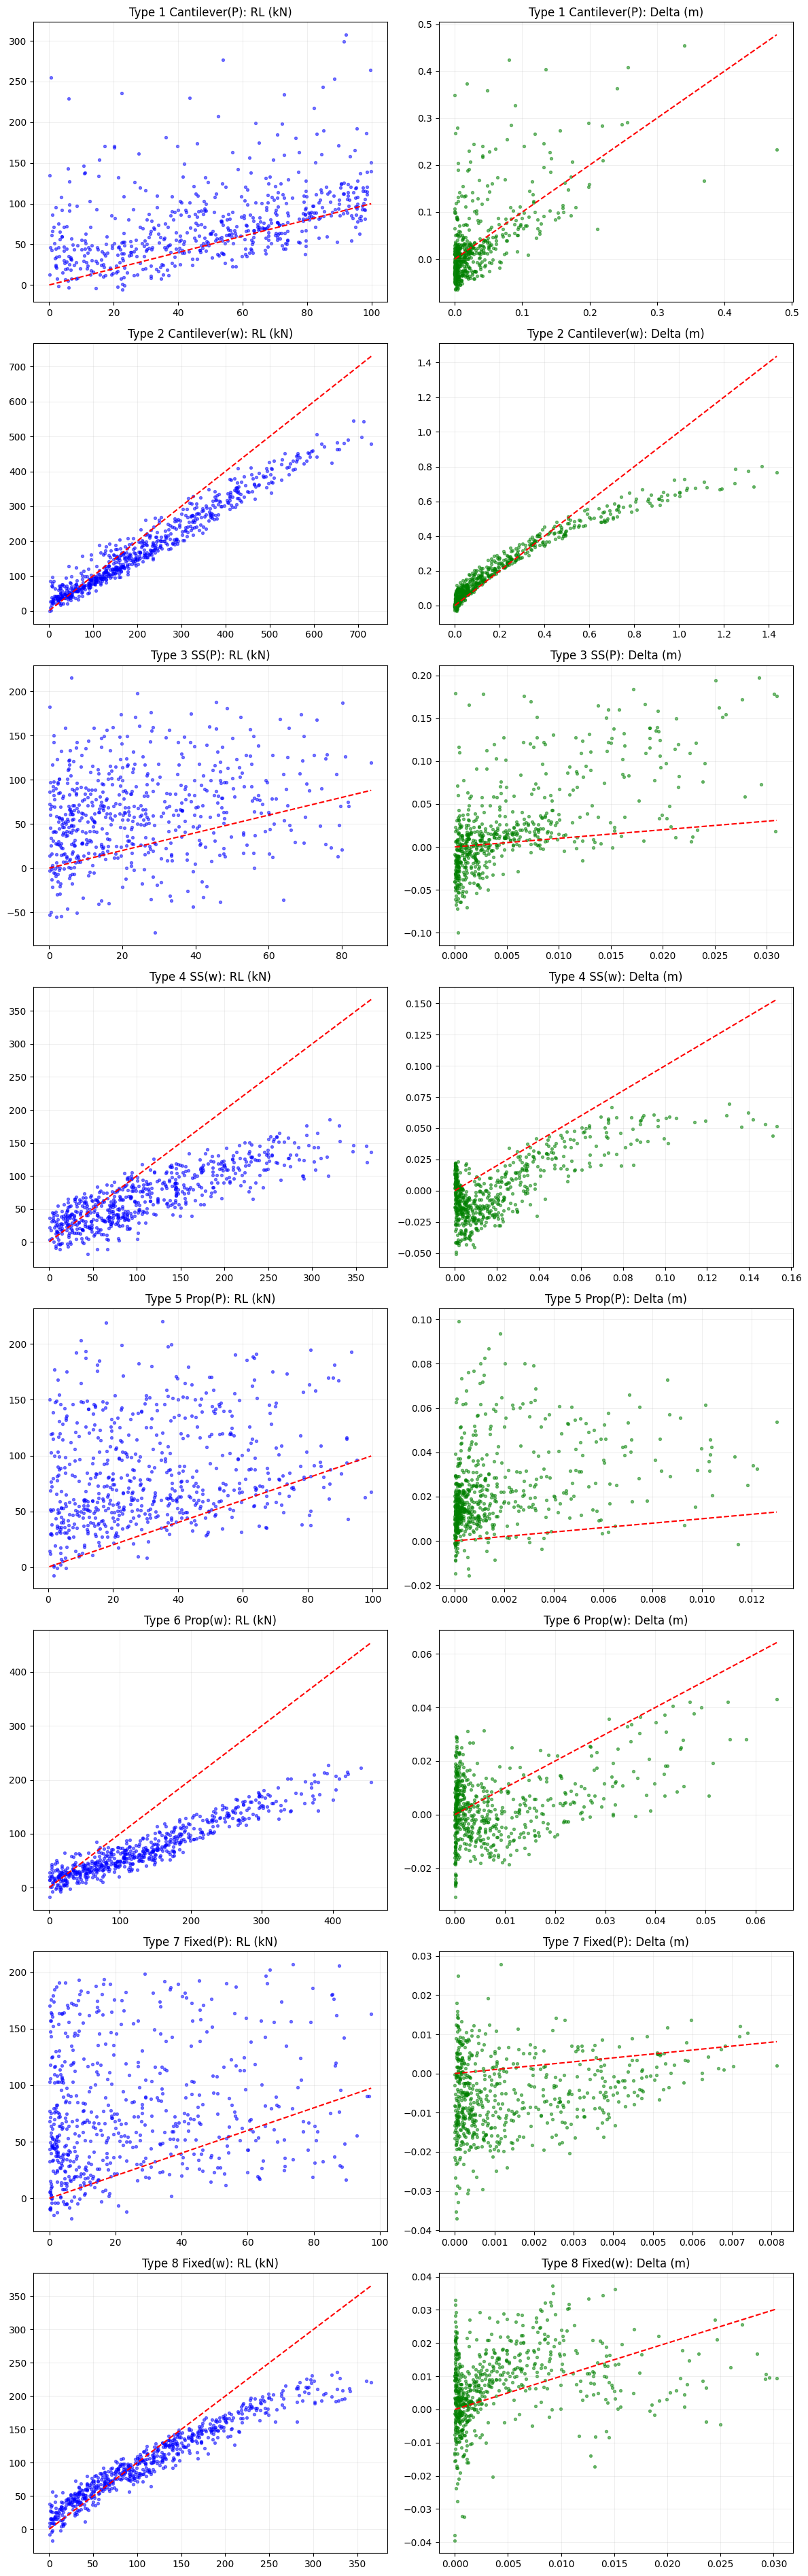

In [10]:
def get_preds(X_inp):
    X_sc = (X_inp - X_m) / X_s
    a1 = np.tanh(np.dot(X_sc, model.W1) + model.b1)
    out_sc = np.dot(a1, model.W2) + model.b2
    return (out_sc * y_s) + y_m

preds = get_preds(X_raw)
fig, axes = plt.subplots(8, 2, figsize=(12, 38))
names = ["Cantilever(P)", "Cantilever(w)", "SS(P)", "SS(w)", "Prop(P)", "Prop(w)", "Fixed(P)", "Fixed(w)"]

for i in range(1, 9):
    mask = df['Type'] == i
    y_true, y_pred = y_raw[mask], preds[mask]
    
    for j, lab in enumerate(['RL (kN)', 'Delta (m)']):
        ax = axes[i-1, j]
        ax.scatter(y_true[:, j], y_pred[:, j], alpha=0.5, s=8, color='blue' if j==0 else 'green')
        # Diagonal Line
        mi, ma = y_true[:, j].min(), y_true[:, j].max()
        ax.plot([mi, ma], [mi, ma], 'r--', lw=1.5)
        ax.set_title(f"Type {i} {names[i-1]}: {lab}")
        ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()